<a href="https://colab.research.google.com/github/VKarpick/powerplay/blob/main/powerplay_gam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Packages

In [1]:
!pip install hockey-rink pygam

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
  Created wheel for hockey-rink: filename=hockey_rink-0.1.7-py3-none-any.whl size=34876 sha256=370e762b3d84f4a3623a324beaf4f36e221af210b5f6f4f41b448b72b821183c
  Stored in directory: /root/.cache/pip/wheels/9b/9c/06/217d4c3a942284788e7fce440ef4e47a8d032cdceb372ff7ec
Successfully built hockey-rink


In [2]:
from copy import deepcopy
from hockey_rink import Rink
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pygam import LogisticGAM
from pygam.terms import TermList, FactorTerm, SplineTerm, TensorTerm
import warnings

# Transforming the Data

The features to be used in the GAM are:
- x and y coordinates of the puckhandler.
- Number of seconds since zone entry or puck recovery.
- Team on the powerplay.
- Team on the penalty kill.
 
The first event after a faceoff is a recovery so faceoff wins are included in puck recoveries.


In [3]:
filename = "https://raw.githubusercontent.com/VKarpick/powerplay/main/data/powerplay_coords.csv"
coords_df = pd.read_csv(filename)

## Dropping Some Rows

There are occasionally puck recoveries that occur in the time that a player is supposed to have possession. Typically, this is the result of a player losing possession in a way that doesn't require an event recorded. The data was manually inspected and frames with these type of errors were identified in [a different notebook](https://github.com/VKarpick/powerplay/blob/main/potential_data_issues.ipynb).

In [4]:
loose_puck_frames = [
    ("2022-02-08 Canada at USA P1 PP1", 719, 733),
    ("2022-02-08 Canada at USA P1 PP2", 1114, 1179),
    ("2022-02-08 Canada at USA P1 PP2", 2853, 2920),
    ("2022-02-08 Canada at USA P2 PP3", 438, 466),
    ("2022-02-08 Canada at USA P2 PP3", 1743, 1782),
    ("2022-02-08 Canada at USA P2 PP5", 1689, 1733),
    ("2022-02-08 ROC at Finland P2 PP5", 2600, 2660),
    ("2022-02-08 ROC at Finland P2 PP5", 2662, 2756),
    ("2022-02-08 ROC at Finland P3 PP6", 375, 403),
    ("2022-02-08 ROC at Finland P3 PP6", 976, 1052),
    ("2022-02-12 Switzerland at ROC P1 PP1", 1106, 1144),
    ("2022-02-12 Switzerland at ROC P1 PP2", 547, 628),
    ("2022-02-12 Switzerland at ROC P3 PP3", 2432, 2451),
    ("2022-02-12 Switzerland at ROC P3 PP5", 463, 502),
    ("2022-02-14 Switzerland at Canada P1 PP1", 5576, 5626),
    ("2022-02-14 Switzerland at Canada P3 PP5", 211, 248),
    ("2022-02-14 USA at Finland P2 PP1", 562, 601),
    ("2022-02-14 USA at Finland P2 PP1", 706, 723),
    ("2022-02-14 USA at Finland P2 PP3", 1042, 1098),
    ("2022-02-14 USA at Finland P2 PP3", 1238, 1454),
    ("2022-02-16 Switzerland at Finland P2 PP3", 5125, 5179),
    ("2022-02-16 Switzerland at Finland P2 PP4", 195, 252),
    ("2022-02-16 Switzerland at Finland P3 PP7", 162, 201),
    ("2022-02-16 Switzerland at Finland P3 PP8", 3107, 3192),
    ("2022-02-16 Switzerland at Finland P3 PP8", 3194, 3265),
    ("2022-02-16 Switzerland at Finland P3 PP8", 3853, 3988),
]

for pp_name, start_frame, end_frame in loose_puck_frames:
    coords_df = coords_df.loc[
        ~((coords_df.pp_name == pp_name) 
          & (coords_df.frame_id.between(start_frame, end_frame)))
    ]

## Target Variable

In [5]:
coords_df["target"] = coords_df.player_area / coords_df.total_area
target = coords_df.target

## Time Features

These plots are meant to give a rough estimate of the amount of time required for zone entries and recoveries to cease to have a noticeable impact on the available space. Will use the values where the plots first hit the average.

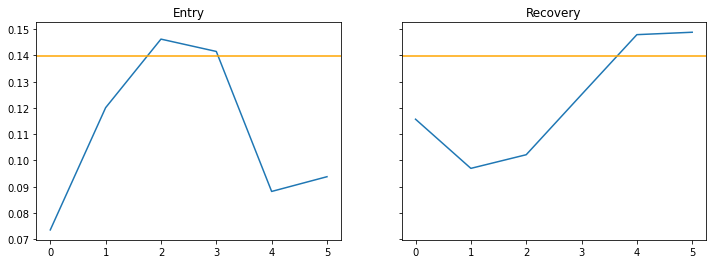

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

mean_pct = coords_df.target.mean()

for ax, event in zip(axs, ("entry", "recovery")):
    event_column = f"time_since_{event}"

    event_times = (
        coords_df
        .loc[coords_df[event_column].between(0, 5)]
        .groupby(event_column)
        ["target"]
        .mean()
    )

    ax.plot(event_times.index, event_times.values)
    ax.axhline(y=mean_pct, color="orange")

    ax.set_title(event.title())

In [7]:
max_evals = 0 #@param
max_entry_time = 2 #@param
max_recovery_time = 4 #@param

## Features

In [8]:
features = (
    coords_df
    .copy()
    [["x", "y", "time_since_entry", "time_since_recovery", "team_name", "opponent"]]
    .rename(columns={"team_name": "pp", "opponent": "pk"})
)

# move everything to the same half of the rink
features.x = (features.x - 100).abs()
features.y = (features.y - 42.5).abs()

# keep everything within the bounds of the ozone, ignoring the curve in the boards
features.x = features.x.clip(25, 100)
features.y = features.y.clip(0, 42.5)

# normalize coordinates
features.x = (features.x - 25) / 75
features.y /= 42.5

# clip entry/recovery times
is_off_recovery = features.time_since_recovery.between(0, max_recovery_time)
features.loc[~is_off_recovery, "time_since_recovery"] = max_recovery_time

is_off_entry = features.time_since_entry.between(0, max_entry_time)
features.loc[~is_off_entry, "time_since_entry"] = max_entry_time

# convert team columns to numbers for use in factor terms
cat_codes = {}
for categorical_column in ["pp", "pk"]:
    factorized_codes = features[categorical_column].factorize()
    features[categorical_column] = factorized_codes[0]
    cat_codes[categorical_column] = list(enumerate(factorized_codes[1]))

In [9]:
features.join(target).head()

,x,y,time_since_entry,time_since_recovery,pp,pk,target
0,0.943102,0.490644,2.0,3.0,0,0,0.093317
1,0.939834,0.498106,2.0,4.0,0,0,0.093917
2,0.942031,0.507933,2.0,4.0,0,0,0.091150
3,0.941982,0.516415,2.0,4.0,0,0,0.090963
4,0.944764,0.517050,2.0,4.0,0,0,0.090178


In [10]:
list(enumerate(features.columns))

[(0, 'x'),
 (1, 'y'),
 (2, 'time_since_entry'),
 (3, 'time_since_recovery'),
 (4, 'pp'),
 (5, 'pk')]

## Creating the Term List for the GAM

In [11]:
def get_terms(params):
    return TermList(
        # coordinates
        *[
            TensorTerm(
                0, 1, 
                n_splines=[int(params["x_splines"]), int(params["y_splines"])],
                lam=[params["x_lam"], params["y_lam"]],
            )
        ],
        # time since entry
        SplineTerm(
            2,
            spline_order=3, 
            n_splines=4,
            lam=params["entry_lam"],
        ),
        # time since recovery
        SplineTerm(
            3,
            spline_order=2,
            n_splines=3,
            lam=params["recovery_lam"],
        ),
        # pp team
        FactorTerm(
            4,
            lam=params["pp_lam"],
        ),
        # pk team
        FactorTerm(
            5,
            lam=params["pk_lam"],
        )
    )

# Hyperparameter Tuning

Parameters to be tuned:
- The number of splines on the tensor terms for the coordinates.
- Smoothing / L2 penalties on all terms.

In [12]:
space = {
    **{
        f"{coord}_splines": hp.quniform(f"{coord}_splines", 10, 30, 1)
        for coord in ("x", "y")
    },
    **{
        f"{feature}_lam": hp.loguniform(f"{feature}_lam", np.log(0.01), np.log(1000.0))
        for feature in ("x", "y", "entry", "recovery", "pp", "pk")
    },
}

A logisitic GAM is used to predict proportions. UBRE is used as the loss because the target variable is bounded.  

Warnings are suppressed because of an underflow issue on a summary statistic that doesn't affect the actual model.  

When max_evals is 0, the best parameters found through tuning are used. Alternatively, the model could've been downloaded from [GitHub](https://github.com/VKarpick/powerplay/tree/main/model) and unpickled, but this seemed easier.

In [13]:
def fit_gam(params):
    terms = get_terms(params)
    gam = LogisticGAM(terms=terms)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gam.fit(features, target)

    return gam


if max_evals == 0:
    best_params = {
        "entry_lam": 6.425971777831048,
        "pk_lam": 362.3408488493783,
        "pp_lam": 160.54622159102445,
        "recovery_lam": 0.03021934566054816,
        "x_lam": 4.782840689702454,
        "x_splines": 12.0,
        "y_lam": 73.87456742413468,
        "y_splines": 14.0,
    }

    best_model = fit_gam(best_params)
else:
    best_model = None
    best_loss = np.Inf


    def objective(params):
        global best_model, best_loss

        gam = fit_gam(params)

        loss = gam.statistics_["UBRE"]

        if loss < best_loss:
            best_loss = loss
            best_model = gam

        return {"loss": loss, "params": params, "status": STATUS_OK}


    trials = Trials()

    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.RandomState(42),
    )

    # create a csv to log the results
    trials_df = pd.DataFrame(trials.trials)
    results = pd.json_normalize(trials_df.result)
    trials_df = trials_df.join(results)

    pickle.dump(best_model, open("powerplay_gam.pkl", "wb"))
    trials_df.to_csv("powerplay_gam_trials.csv", index=False)

In [14]:
best_params

{'entry_lam': 6.425971777831048,
 'pk_lam': 362.3408488493783,
 'pp_lam': 160.54622159102445,
 'recovery_lam': 0.03021934566054816,
 'x_lam': 4.782840689702454,
 'x_splines': 12.0,
 'y_lam': 73.87456742413468,
 'y_splines': 14.0}

# Inspecting the Results

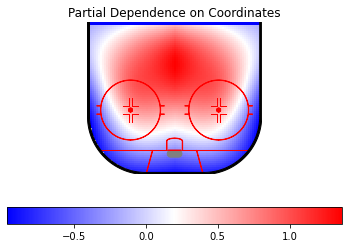

In [15]:
x = np.arange(25, 101)
y = np.arange(0, 43)
XX = tuple(np.meshgrid((x - 25) / 75, y / 42.5))
Z = best_model.partial_dependence(term=0, X=XX, meshgrid=True)
x, y = np.meshgrid(x, y)

rink = Rink(rotation=270)
ax = rink.draw(display_range="ozone");

heatmap = rink.heatmap(
    x.flatten(), y.flatten(), 
    values=Z.flatten(), 
    statistic="mean",
    symmetrize=True, 
    binsize=1,
    cmap="bwr", 
    ax=ax,
)

plt.colorbar(heatmap, ax=ax, orientation="horizontal")
ax.set_title("Partial Dependence on Coordinates");

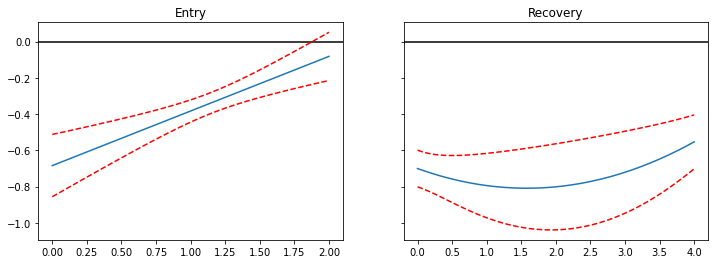

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

for i, (term, title, ax) in enumerate(zip(best_model.terms[1:3], ("Entry", "Recovery"), axs)):
    term_idx = i + 1
    XX = best_model.generate_X_grid(term=term_idx)
    pdep, confi = best_model.partial_dependence(term=term_idx, X=XX, width=0.95)

    ax.axhline(y=0, color="black")
    ax.plot(XX[:, term.feature], pdep)
    ax.plot(XX[:, term.feature], confi, c="r", ls="--")
    ax.set_title(title)

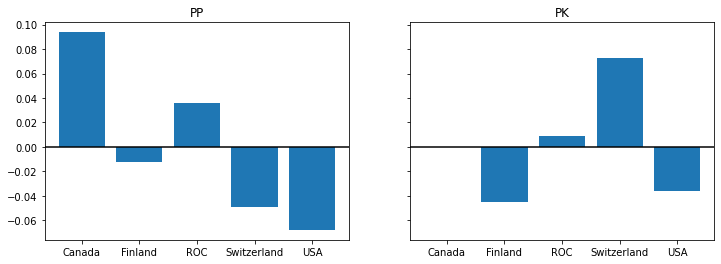

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

for i, (coef_idx, title, ax) in enumerate(zip((-11, -6), ("pp", "pk"), axs)):
    term_idx = i + 3
    coefs = best_model.coef_[coef_idx:coef_idx + 5]
    teams = [cat_code[1] for cat_code in cat_codes[title]]

    ax.axhline(y=0, color="black")
    ax.bar(*zip(*sorted(tuple(zip(teams, coefs)))))
    ax.set_title(title.upper())